In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mobius import Planner, SequenceGA, FindMe
from mobius import MHFingerprint
from mobius import GPModel, ExpectedImprovement, TanimotoSimilarityKernel
from mobius import homolog_scanning, monomers_scanning

/home/eberhardt/Applications/mambaforge/envs/mm/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [4]:
# This is the peptide sequence we need to find
# See http://cycpeptmpdb.com/peptides/id_7170/ for more information
target = 'PEPTIDE1{[ac].P.[Me_dL].T.[d1-Nal].[Nva].[dL].[Me_dA].L.P}$PEPTIDE1,PEPTIDE1,4:R3-10:R2$$$V2.0'

In [5]:
# Here we use the (folded) MinHashed Fingerprint method
mhfp = MHFingerprint(input_type='helm', dimensions=4096, radius=3)
kernel = TanimotoSimilarityKernel()

# Here we define the FindMe emulator
fm = FindMe(target, input_type='helm', kernel=kernel, input_transformer=mhfp)

In [31]:
lead = 'PEPTIDE1{E.P.L.T.A.K.I.G.L.P}$PEPTIDE1,PEPTIDE1,4:R3-10:R2$$$V2.0'

seed_library = [lead]

for seq in homolog_scanning(lead):
    seed_library.append(seq)

    if len(seed_library) >= 48:
        print('Reach max. number of peptides allowed.')
        break

for seq in monomers_scanning(lead, monomers=['Me_dL', 'd1-Nal', 'Nva', 'dL', 'Me_dA']):
    seed_library.append(seq)

    if len(seed_library) >= 96:
        print('Reach max. number of peptides allowed.')
        break

#seed_library.append('PEPTIDE1{[d1-Nal].[d1-Nal].[d1-Nal].T.[d1-Nal].[d1-Nal].[d1-Nal].[d1-Nal].[d1-Nal].P}$PEPTIDE1,PEPTIDE1,4:R3-10:R2$$$V2.0')

# And we test right away the seed library using our emulator
scores_seed_library = fm.score(seed_library)

Reach max. number of peptides allowed.


In [32]:
gpmodel = GPModel(kernel=TanimotoSimilarityKernel(), input_transformer=mhfp)
acq = ExpectedImprovement(gpmodel, maximize=True)

In [33]:
yaml_content = """
design:
  monomers:
    default: [A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y]
    special: [Me_dL, d1-Nal, Nva, dL, Me_dA]
    nter : [ac]
  polymers:
    - PEPTIDE1{X.X.X.T.X.X.X.X.X.P}$PEPTIDE1,PEPTIDE1,4:R3-10:R2$$$V2.0:
        PEPTIDE1:
          1: [default, nter]
          2: [default, special]
          3: [default, special]
          5: [default, special]
          6: [default, special]
          7: [default, special]
          8: [default, special]
          9: [default, special]
"""

with open('sampling_macrocycle.yaml', 'w') as f:
    f.write(yaml_content)

In [34]:
optimizer = SequenceGA(algorithm='GA', period=15, design_protocol_filename='sampling_macrocycle.yaml')
ps = Planner(acq, optimizer)

In [50]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [(0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommand(peptides, scores.reshape(-1, 1), batch_size=96)

    # Here you can add whatever methods you want to further filter out peptides

    # Virtually test the suggested peptides using the MHC emulator
    # You know the drill now, this is for benchmarking or demonstration
    # purposes only and should be replaced with actual lab experiments.
    scores_suggested_peptides = fm.score(suggested_peptides)

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([(i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmax(scores)]
    best_scores = np.max(scores)
    print('Best peptide found so far: %s / %.3f' % (best_seq, best_scores))

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'score'))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        0 |  9.994160E+02 |  9.993780E+02
     2 |      500 | -2.903180E-05 | -2.029716E-03
     3 |     1000 | -8.865342E-05 | -2.364596E-03
     4 |     1500 | -2.189490E-04 | -2.392965E-03
     5 |     2000 | -5.199711E-04 | -4.965979E-03
     6 |     2500 | -9.533100E-04 | -4.965979E-03
     7 |     3000 | -1.458751E-03 | -4.965979E-03
     8 |     3500 | -2.033894E-03 | -4.987604E-03
     9 |     4000 | -2.576034E-03 | -5.691616E-03
    10 |     4500 | -3.123389E-03 | -6.048419E-03
    11 |     5000 | -3.625009E-03 | -6.048419E-03
    12 |     5500 | -4.075077E-03 | -6.048419E-03
    13 |     6000 | -4.405795E-03 | -6.048419E-03
    14 |     6500 | -4.617650E-03 | -6.048419E-03
    15 |     7000 | -4.780336E-03 | -6.048419E-03
    16 |     7500 | -4.886410E-03 | -6.048419E-03
    17 |     8000 | -4.963850E-03 | -6.048419E-03
    18 |     8500 | -5.001883E-03 | -6.048419E-03
    19 |     9000 | -5.032370E-03 | -6.048419E-03


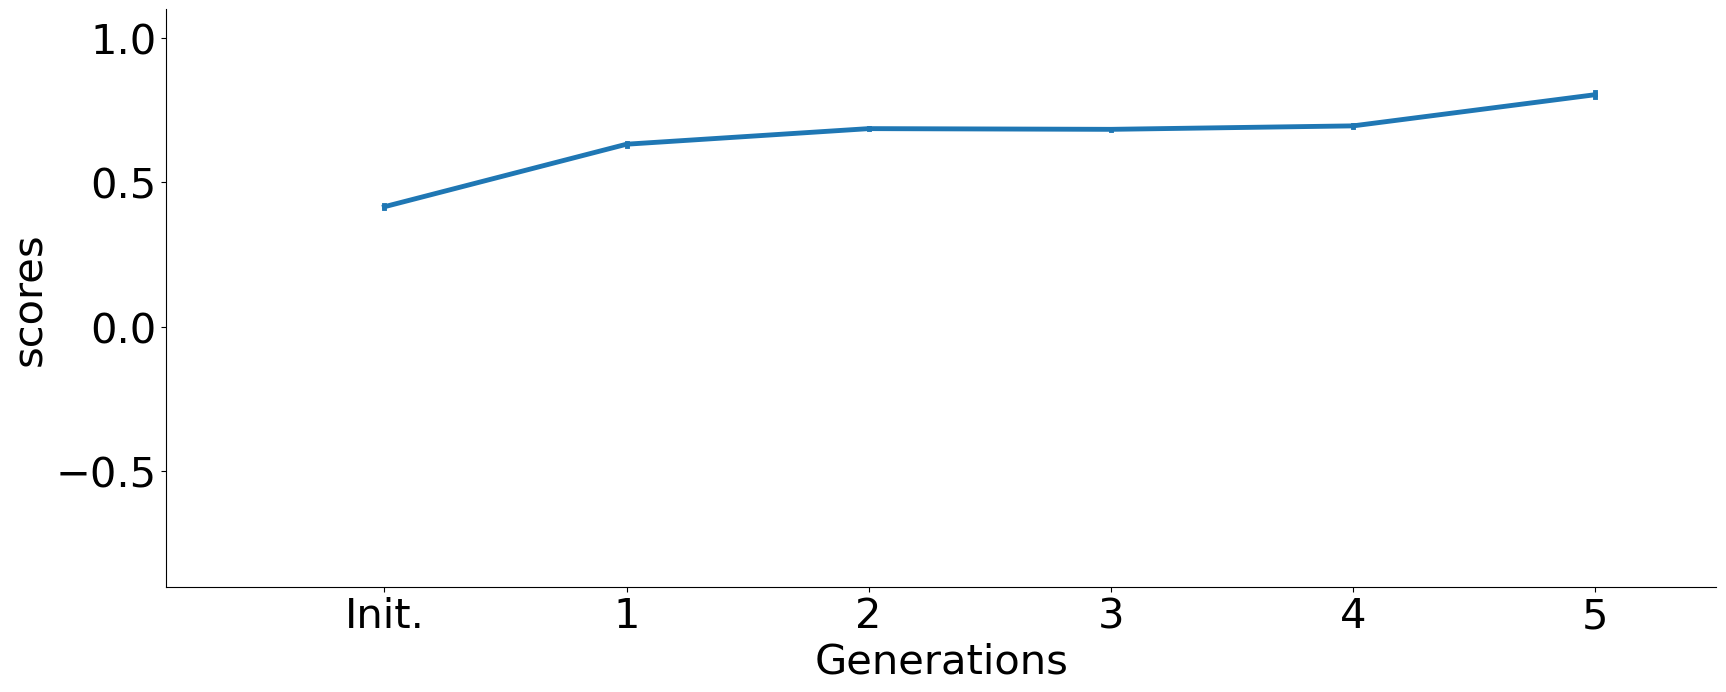

In [51]:
fig, ax = plt.subplots(figsize=(20, 7.5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='score', data=df, ax=ax, errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-0.9, 1.1])
ax.set_ylabel('scores', fontsize=30)
ax.set_xlabel('Generations', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()